# 2D Модель Изинга

В этот ноутбуке реализована 2D-модель Изинга на квадратной решетке. Модель Изинга - это простая модель, которую можно использовать для демонстрации магнетизма. Он состоит из спинов $1/2$, расположенных на решетке с взаимодействиями с ближайшими соседями (NN).

### Гамильтониан

Гамильтониан модели Изинга со спином $1/2$ может быть записан как
\begin{align}
𝐻 = 𝐽 \ \sum_{\langle 𝑖𝑗 \rangle} \sigma^𝑧_𝑖 \sigma^𝑧_𝑗 − ℎ\ \Sigma_i \sigma^𝑧_𝑖,
\end{align}

### Алгоритм Метрополиса:

При заданной температуре $T$ возможное состояние решетки может быть определено с помощью алгоритма Метрополиса, в котором Монте-Карло реализуется путем изменения конфигурации одного спина. он состоит из следующих этапов-

a) Выберем случайный спин $[i,j]$;

б) Вычислим $\delta E$ - изменение энергии после изменения спина в точке $[i,j]$ на противоположный;

в) Выберем новую конфигурацию, если $\delta E<0$, или если $\delta E >0$, затем выберем новое состояние с вероятностью $\exp(-\beta\delta E)$.

d) Повторим шаги с a) по б) по крайней мере для $L ^ 3$ итераций. Лучше выбрать еще больше итераций, например, $ 10 L ^ 3$, чтобы было достаточно шагов Монте-Карло для термализации системы.

### Измерение физических величин

Для того чтобы измерить физическую величину, необходимо провести выборку в нескольких конфигурациях. На практике мы будем использовать алгоритм Метрополиса для термализации системы (используя, например, $ L ^ 2$ шагов Монте-Карло). После этого в системе выполняется измерение после каждого шага Монте-Карло. Впоследствии можно получить среднее значение всех этих измерений. Мы будем вычислять следующие величины:

#### Намагниченность на единицу площади:
\begin{align}
m = \langle \sigma^z \rangle = \sum_i \sigma_i^z / L^2
\end{align}

#### Магнитная восприимчивость:

\begin{align}
\chi =  \lim_{h\rightarrow 0}  \frac{\partial m}{\partial h} \approx \frac{\langle m^2 \rangle  - \langle m \rangle ^2}{T}
\end{align}

#### Энергия на единицу площади:

\begin{align}
E = \frac{\langle H \rangle }{L^2}
\end{align}

#### Удельная теплоемкость:

\begin{align}
C_V = \frac{\langle E^2 \rangle - \langle E \rangle ^2}{T^2}
\end{align}


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

In [27]:
# Параметры
# L: размер сетки
# j_nn: энергия взаимодействия между соседями
# h : внешнее магнитное поле 
# thi, tlo, tstep : начальная, конечная температуры и шаг
# ntemp : число температурных точек
# iterations : число иттераций
# n_meas : число измерений для величин
# msteps : число шагов МК перед кашдым наблюдением (МК - Монте-Карло)

L=100;
j_nn = -1.0
h = 0.6;
thi = 5.0
tlo = 0.5
tstep = -0.1
ntemp = -int((thi-tlo)/tstep);
iterations = 10*L**3;
n_meas = 10; mstep = 50;

In [28]:
def Magnetization(Lattice,L):
    "Вычисляем <m> и <m^2> у решетки"
    return sum(sum(Lattice))/L**2, sum(sum(Lattice**2))/L**2

def Energy(Lattice,L,j_nn,h):
    "Вычисляем <E> and <E^2> для каждого спина"
    e = 0.0; e2=0.0
    for x in range(L):
        for y in range(L):
            # nearest neighbors are (x,y1)(x,y2)(x1,y)(x2,y)
            x1,x2,y1,y2=(x-1)%L,(x+1)%L,(y-1)%L,(y+1)%L;
            e += h*Lattice[x,y] +j_nn*Lattice[x,y]*(Lattice[x,y1]+Lattice[x,y2]+Lattice[x1,y]+Lattice[x2,y]);
            e2+= (h*Lattice[x,y] +j_nn*Lattice[x,y]*(Lattice[x,y1]+Lattice[x,y2]+Lattice[x1,y]+Lattice[x2,y]))**2;
            
    return e/(2*L**2), e2/(4*L**2)


In [29]:
#инициализация всех массивов

lattice = np.zeros((L,L),dtype=int);
lattice = random.randint(2,size=(L,L))
lattice = 2*lattice-1

temperatures = np.linspace(thi,tlo,ntemp)

magnetization  = np.zeros(ntemp)
temperature    = np.zeros(ntemp)
susceptibility = np.zeros(ntemp)
energy         = np.zeros(ntemp)
specific_heat  = np.zeros(ntemp)
lattice_save   = np.zeros((ntemp,L,L),dtype=int)

In [30]:
# Охлаждение решетки
step = 0;
for temp in temperatures:
    
    m = 0.0; chi = 0.0; e = 0.0; cv = 0.0;
    
    for i in range(iterations):
        
        # Реализация Монте-Карло
        
        # Выбираем случайный спин
        x = random.randint(L)
        y = random.randint(L)
        # Ближайшие соседи - (x,y1)(x,y2)(x1,y)(x2,y)
        x1, x2, y1, y2 = (x-1)%L, (x+1)%L, (y-1)%L, (y+1)%L
        
        # Считаем изменение энергии и вероятности
        de = 2*h*lattice[x,y]- 2*j_nn*lattice[x,y]*(lattice[x,y1]+lattice[x,y2]+lattice[x1,y]+lattice[x2,y])
        r = random.random()
        
        if (de < 0.0 or r < np.exp(-de/temp)): #если поменять спин энергетически выгодно/наиболее вероятно
            lattice[x,y] = -1 * lattice[x,y]   # меняем спин
            
           
    for i in range((n_meas-1)*mstep+1):
        #тут аналогично
        x = random.randint(L)
        y = random.randint(L)
    
        x1, x2, y1, y2 = (x-1)%L, (x+1)%L, (y-1)%L, (y+1)%L
        
        de = 2*h*lattice[x,y]- 2*j_nn*lattice[x,y]*(lattice[x,y1]+lattice[x,y2]+lattice[x1,y]+lattice[x2,y])
        r = random.random();
        
        if (de<0.0 or r < np.exp(-de/temp)): 
            lattice[x,y]=-1*lattice[x,y]     
        
        if (i%mstep == 0):
            m1, m2 = Magnetization(lattice,L); e1,e2 = Energy(lattice,L,j_nn,h)
            m += m1; chi += (m2 - m1**2)/temp
            e += e1; cv  += (e2 - e1**2)/temp**2    
     
    #усредняем набранную статистику
    magnetization[step] = m/n_meas
    susceptibility[step] = chi/n_meas
    energy[step] = e/n_meas
    specific_heat[step] = cv / n_meas; 
    lattice_save[step,:,:] = lattice[:,:]
    step +=1

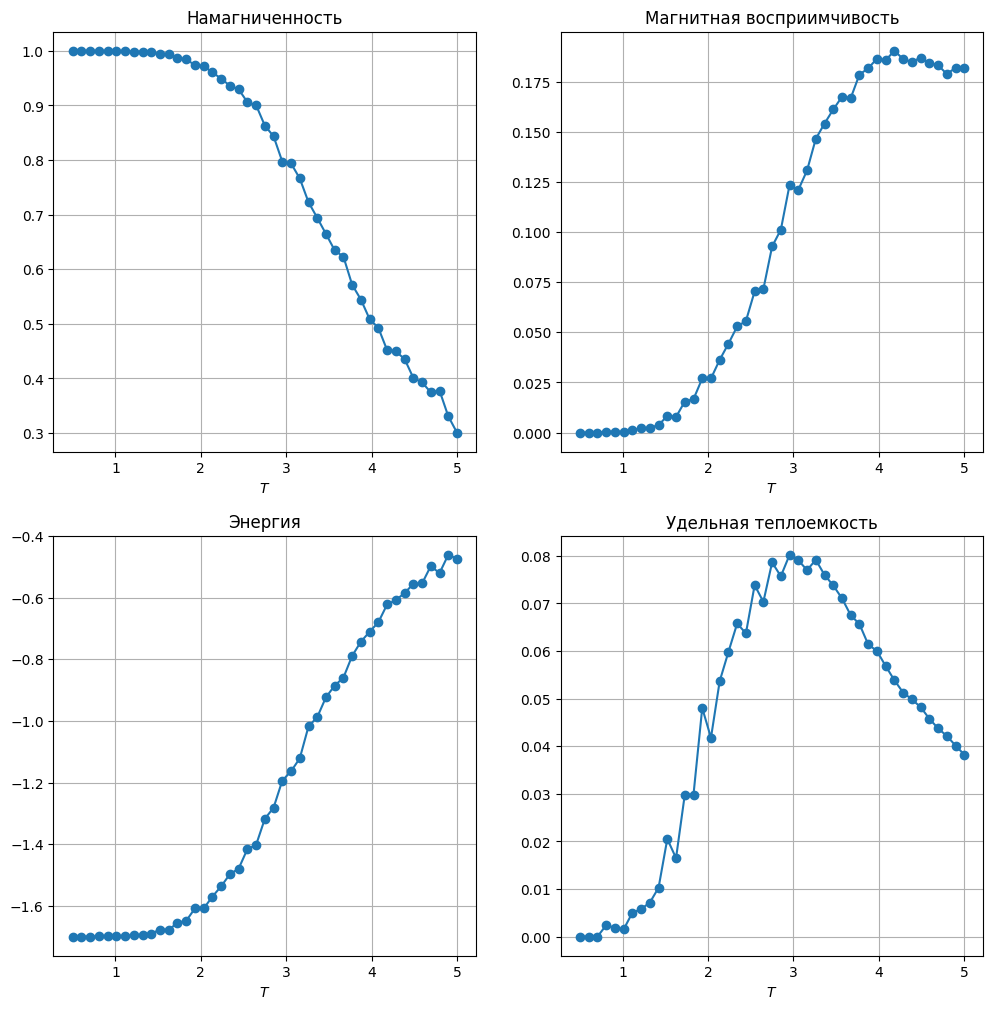

In [33]:
# отрисовываем зависимость характеристик системы от температуры

names = ["Намагниченность", "Магнитная восприимчивость", "Энергия", "Удельная теплоемкость"]

types = [magnetization, susceptibility, energy, specific_heat]
plt.figure(figsize=(12,12))

for i in range(4):
    plt.subplot(221 + i)
    plt.title(names[i])
    plt.grid()
    plt.xlabel(r'$T$')
    plt.plot(temperatures,types[i],'-o')

plt.savefig('Observables.pdf',format='pdf')

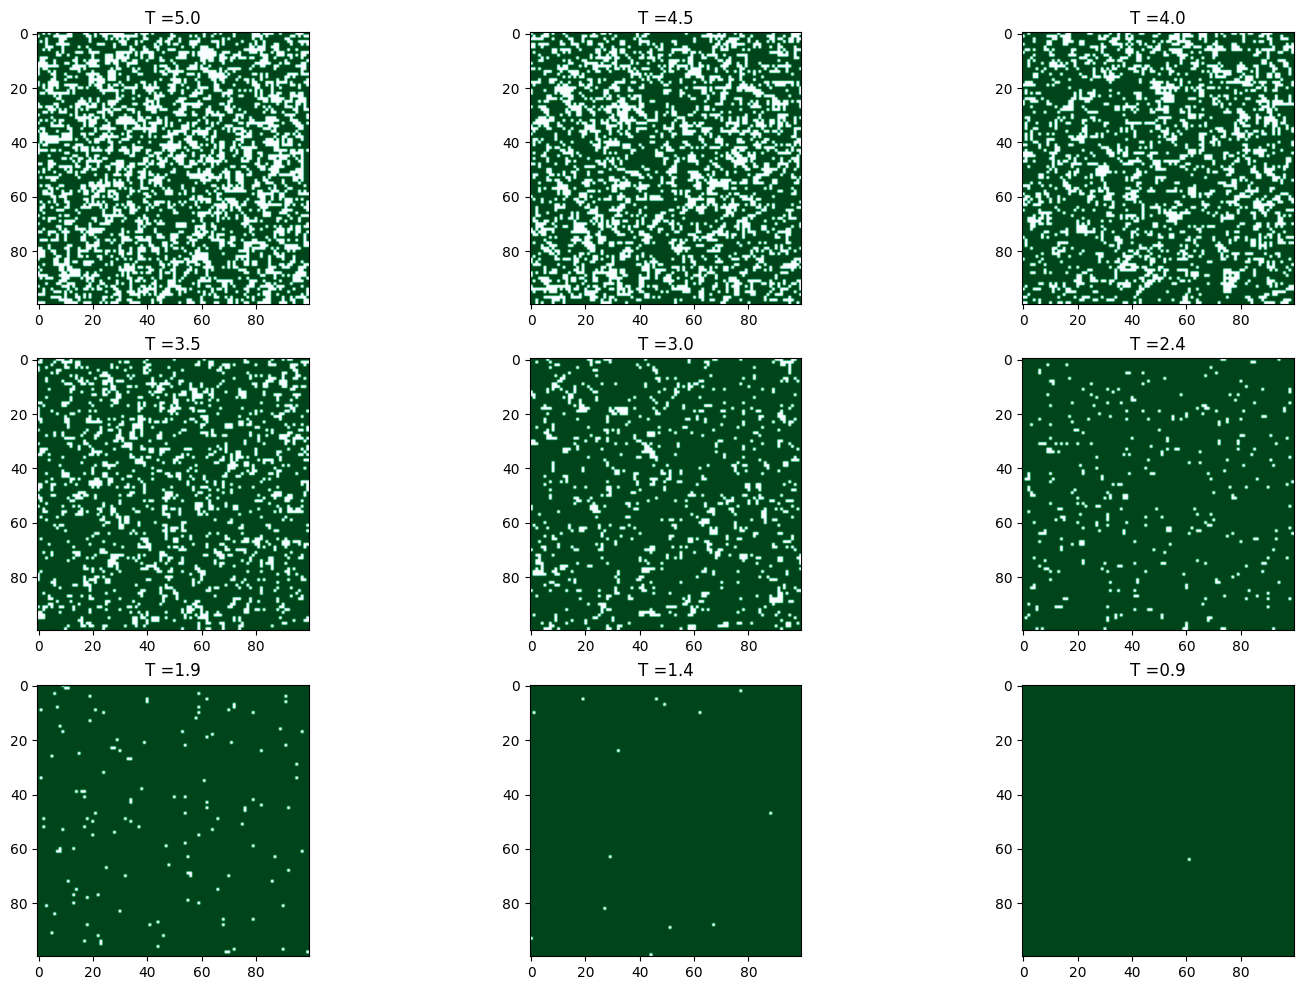

In [34]:
# визуализация решетки спинов
#зеленый 1, белый -1

plt.figure(figsize=(18,12))

for i in range(9):
    plt.subplot(331 + i)
    plt.title('T =' + '%.1f' % temperatures[i*5])
    plt.imshow(lattice_save[i*5,:,:], cmap='BuGn')

plt.savefig('Lattice_config.pdf',format='pdf')